## Exploring supervised learning

### *Imports* and general functions

In [ ]:
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.utils import resample

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [ ]:
"Creates hist plot of a dataset's column"
def createHistPlot(dataset, columnName, title, xlabel):
  dataset[columnName].plot(kind="hist", bins=15)
  plt.xlabel(xlabel)
  plt.ylabel("Number of entries")
  plt.title(title)
  return plt

In [ ]:
"Creates bar plot of a dataset's column"
def createBarPlot(dataset, columnName, title, xlabel):
  if columnName == "":
    dataset.value_counts().plot(kind='bar', figsize = (10, 8))
  else :
    dataset[columnName].value_counts().plot(kind='bar', figsize = (10, 8))
  plt.xlabel(xlabel)
  plt.ylabel("Number of entries")
  plt.title(title)
  return plt

In [ ]:
"Features scaling a column using standard or robust scaler"
def featureScaler(dataset, columnName, scaler):
  if scaler == "standard":
    return StandardScaler().fit_transform(dataset[[columnName]].astype(float).values)
  elif scaler == "robust":
    transformer = RobustScaler().fit(dataset[[columnName]])
    return transformer.transform(dataset[[columnName]])
  else:
    print("Scaler feature [{}] not supported. Any operation was performed over the column".format(scaler))
    return dataset[columnName]

In [ ]:
"Removes a particular column by name from a specific dataset"
def removeColumnFromDataset(dataset, columnName):
  return dataset.drop(columnName, axis=1)

In [ ]:
"Generates ROC curve plot due a 'y' array and its predictions"
def generateRoc(test_y, y_pred):
  lw=2

  fpr, tpr, thresholds = roc_curve(test_y, y_pred, pos_label=1)

  plt.plot(fpr, tpr, color="green", label='ROC curve (AUC area = %0.2f)' % auc(fpr, tpr), lw=lw)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic (ROC)')
  plt.legend(loc="lower right")
  plt.show()

In [ ]:
"Generates confusion matrix plot"
"Taken from https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea"
def generateConfusionMatrixPlot(test_y, y_pred):
  cm = confusion_matrix(test_y, y_pred)
  group_names = ['True Neg', 'False Pos', 'False Neg' , 'True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

  plt.title('Confusion matrix plot')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [ ]:
"Print different metrics"
def printMetrics(test_y, y_pred):
  accuracy = accuracy_score(test_y, y_pred)
  cm = confusion_matrix(test_y, y_pred)
  c_report = classification_report(test_y, y_pred)
  fpr, tpr, thresholds = roc_curve(test_y, y_pred, pos_label=1)
  auc_result = auc(fpr, tpr)

  print("Accuracy: ", accuracy)
  print("\nAUC: ", auc_result)
  print("\nConfusion matrix:\n", cm)
  print("\nClassification report:\n", c_report)

### I Part: *Red wine quality dataset* 

#### 1. Preprocessing and feature extraction

##### a. Data load

In [ ]:
df = pd.read_csv("winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


##### b. Data exploration

In [ ]:
df.info()
# There are not null values in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [ ]:
(df.quality.value_counts() / len(df)) * 100.0

5    42.589118
6    39.899937
7    12.445278
4     3.314572
8     1.125704
3     0.625391
Name: quality, dtype: float64

In [ ]:
df.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

An imbalance of the classes can be noted, where quality 5 and 6 are the ones with the greatest presence in the data set, and classes 3 and 8 the least.

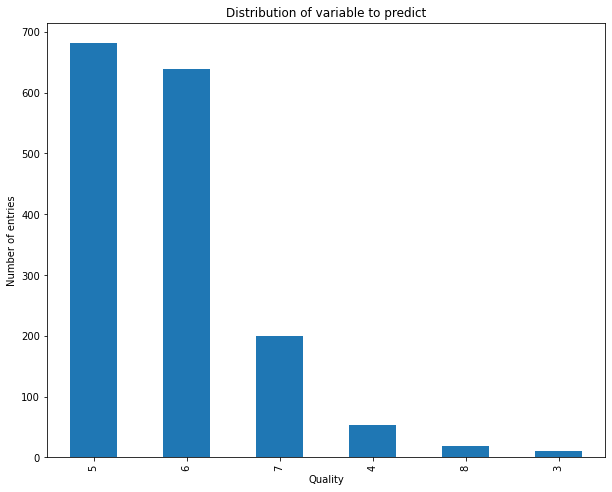

In [ ]:
createBarPlot(df, 'quality', 'Distribution of variable to predict', 'Quality').show()

##### c. Standarize data

"*Robust*" is used to try to lessen the impact of possible "*outliers*" on the data.

In [ ]:
df["fixed acidity"] = featureScaler(df, "fixed acidity", "robust")
df["volatile acidity"] = featureScaler(df, "volatile acidity", "robust")
df["citric acid"] = featureScaler(df, "citric acid", "robust")
df["residual sugar"] = featureScaler(df, "residual sugar", "robust")
df["chlorides"] = featureScaler(df, "chlorides", "robust")
df["free sulfur dioxide"] = featureScaler(df, "free sulfur dioxide", "robust")
df["total sulfur dioxide"] = featureScaler(df, "total sulfur dioxide", "robust")
df["density"] = featureScaler(df, "density", "robust")
df["pH"] = featureScaler(df, "pH", "robust")
df["sulphates"] = featureScaler(df, "sulphates", "robust")
df["alcohol"] = featureScaler(df, "alcohol", "robust")

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.238095,0.72,-0.787879,-0.428571,-0.15,-0.214286,-0.100,0.469799,1.052632,-0.333333,-0.50,5
1,-0.047619,1.44,-0.787879,0.571429,0.95,0.785714,0.725,0.022371,-0.578947,0.333333,-0.25,5
2,-0.047619,0.96,-0.666667,0.142857,0.65,0.071429,0.400,0.111857,-0.263158,0.166667,-0.25,5
3,1.571429,-0.96,0.909091,-0.428571,-0.20,0.214286,0.550,0.559284,-0.789474,-0.222222,-0.25,6
4,-0.238095,0.72,-0.787879,-0.428571,-0.15,-0.214286,-0.100,0.469799,1.052632,-0.333333,-0.50,5


##### d. Covariance and correlation

In [ ]:
display(df.cov())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,0.687396,-0.152098,0.328745,0.191671,0.182826,-0.095269,-0.077171,0.467716,-0.460115,0.142884,-0.034054,0.083059
volatile acidity,-0.152098,0.512998,-0.233595,0.002767,0.103317,-0.005621,0.045043,0.013322,0.136731,-0.176032,-0.096501,-0.225904
citric acid,0.328745,-0.233595,0.348462,0.170711,0.283140,-0.026894,0.017250,0.181919,-0.259930,0.173867,0.043211,0.107915
residual sugar,0.191671,0.002767,0.170711,4.056933,0.263584,0.281491,0.336301,0.604289,-0.140183,0.010484,0.056445,0.022336
chlorides,0.182826,0.103317,0.283140,0.263584,5.537857,0.009780,0.091733,0.398697,-0.506775,0.822744,-0.346610,-0.244977
free sulfur dioxide,-0.095269,-0.005621,-0.026894,0.281491,0.009780,0.558239,0.410246,-0.013846,0.042727,0.036346,-0.034540,-0.030565
total sulfur dioxide,-0.077171,0.045043,0.017250,0.336301,0.091733,0.410246,0.676314,0.049494,-0.044434,0.033260,-0.112645,-0.122931
density,0.467716,0.013322,0.181919,0.604289,0.398697,-0.013846,0.049494,0.713087,-0.234461,0.118095,-0.279069,-0.119286
pH,-0.460115,0.136731,-0.259930,-0.140183,-0.506775,0.042727,-0.044434,-0.234461,0.660254,-0.150473,0.111288,-0.037883
sulphates,0.142884,-0.176032,0.173867,0.010484,0.822744,0.036346,0.033260,0.118095,-0.150473,0.886809,0.058704,0.191186


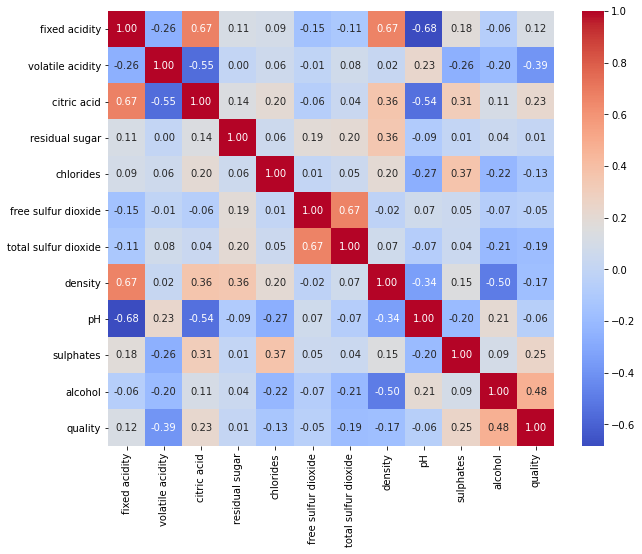

In [ ]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")

#### 2. Partición y generación de conjunto de datos

##### a. Convertir los valores de la columna "*quality*" a una representación binaria

Antes de obtener los subconjuntos de datos para entrenamiento y testing vamos a revisar la distribución de la variable objetivo si utilizamos 2 umbrales diferentes para crear la categoría 0 y la categoría 1.

###### a.1. Primer enfoque

Una calificación de 3-6 representa un vino de mala calidad (los convertiremos a 0), por otro lado, una calificación de 7-8 representa un vino de buena calidad (los convertiremos a 1).

Una vez que convertimos los datos en un problema de clasificación binaria podemos ver que el desbalance se mantiene.

Tenemos un 86.4% de vinos de mala calidad y un 13.6% de vinos de mala calidad.

In [ ]:
d = {3:0, 4:0, 5:0, 6:0, 7:1, 8:1}
df_copy = df.copy()
df_copy["quality"] = df_copy["quality"].apply(lambda x:d[x])
(df_copy.quality.value_counts() / len(df_copy)) * 100.0

0    86.429018
1    13.570982
Name: quality, dtype: float64

In [ ]:
df_copy.quality.value_counts()

0    1382
1     217
Name: quality, dtype: int64

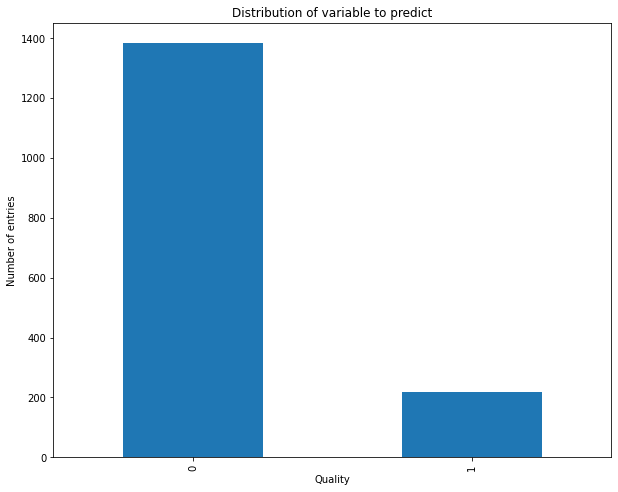

In [ ]:
createBarPlot(df_copy, 'quality', 'Distribution of variable to predict', 'Quality').show()

###### a.2. Segundo enfoque

Una calificación de 3-5 representa un vino de mala calidad (los convertiremos a 0), por otro lado, una calificación de 6-8 representa un vino de buena calidad (los convertiremos a 1).

Al convertir el problema a uno de clasificación binaria utilizando este segundo umbral mencionado la distribución cambia considerablemente, no se alcanza un 50-50, sin embargo, se obtiene una distribución con un desbalance mucho menor.

Tenemos un 46.5% de vinos de mala calidad y un 53.5% de vinos de mala calidad.

In [ ]:
d_2 = {3:0, 4:0, 5:0, 6:1, 7:1, 8:1}
df_other_copy = df.copy()
df_other_copy["quality"] = df_other_copy["quality"].apply(lambda x:d_2[x])
(df_other_copy.quality.value_counts() / len(df_other_copy)) * 100.0

1    53.470919
0    46.529081
Name: quality, dtype: float64

In [ ]:
df_other_copy.quality.value_counts()

1    855
0    744
Name: quality, dtype: int64

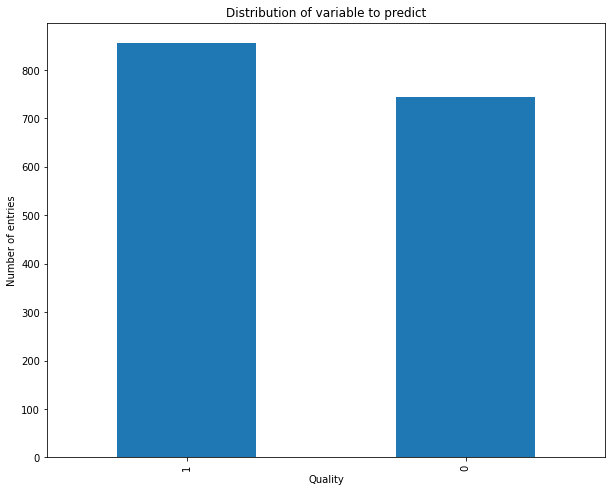

In [ ]:
createBarPlot(df_other_copy, 'quality', 'Distribution of variable to predict', 'Quality').show()

Los experimentos los realizaremos sobre ambas distribuciones de la variable objetivo, así podremos comparar su comportamiento y decidir cuál funciona mejor.

##### b. Particionar el conjunto de datos en entrenamiento y pruebas

In [ ]:
# Represents the % of data to be included in the training subset
# e.g. 0.7 represents 80% of the data
training_size=0.8
# Represents 100% - training size percentage
testing_size=float('%.3f'%(1.0-training_size))

#K fold partitions
K = 10

X = removeColumnFromDataset(df, "quality")
y = df["quality"]

train_x, test_x, train_y, test_y = train_test_split(X, y, train_size=training_size, test_size=testing_size, stratify=y)

# prepare the cross-validation procedure
cv = KFold(n_splits=K, random_state=2652124, shuffle=True)

Con el objetivo de entrenar y probar con los mismos subconjuntos de datos, primero hicimos el train_test_split y luego cambiamos los valores de 'y'.

Escenario 1.

In [ ]:
train_y_umbral_1 = train_y.copy()

train_y_umbral_1 = train_y_umbral_1.apply(lambda x:d[x])

test_y_umbral_1 = test_y.copy()
test_y_umbral_1 = test_y_umbral_1.apply(lambda x:d[x])

Escenario 2.

In [ ]:
train_y_umbral_2 = train_y.copy()

train_y_umbral_2 = train_y_umbral_2.apply(lambda x:d_2[x])

test_y_umbral_2 = test_y.copy()
test_y_umbral_2 = test_y_umbral_2.apply(lambda x:d_2[x])

#### 3. *Grid search* para encontrar la mejor configuración de hiperparámetros para cada modelo

In [ ]:
# create models
lr_model = LogisticRegression()
dt_model = DecisionTreeClassifier()
knn_model = KNeighborsClassifier()
nn_model = MLPClassifier()

##### Regresión logística

In [ ]:
# Setting hyperparameters to test
solver = ['liblinear', 'saga', 'lbfgs', 'sag']
max_iter = [200, 400]
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, solver=solver, max_iter=max_iter)

# Create grid search using K-fold cross validation
clf = GridSearchCV(lr_model, hyperparameters, cv=cv, verbose=0)

###### Escenario 1: calidad 3-6: mala, calidad 7-8: buena.

In [ ]:
# Fit grid search
best_model = clf.fit(train_x, train_y_umbral_1)

In [ ]:
# View best hyperparameters
print('Best penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
print('Best solver:', best_model.best_estimator_.get_params()['solver'])
print('Best max_iter:', best_model.best_estimator_.get_params()['max_iter'])

Best penalty: l2
Best C: 2.7825594022071245
Best solver: liblinear
Best max_iter: 200


In [ ]:
# Prediction using the best model
y_pred = best_model.predict(test_x)

printMetrics(test_y_umbral_1, y_pred)

Accuracy:  0.865625

AUC:  0.637519939551675

Confusion matrix:
 [[263  14]
 [ 29  14]]

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92       277
           1       0.50      0.33      0.39        43

    accuracy                           0.87       320
   macro avg       0.70      0.64      0.66       320
weighted avg       0.85      0.87      0.85       320



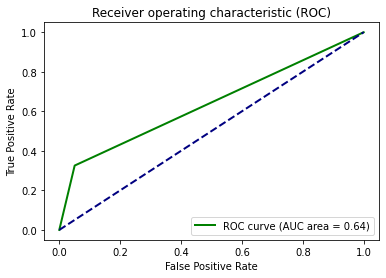

In [ ]:
generateRoc(test_y_umbral_1, y_pred)

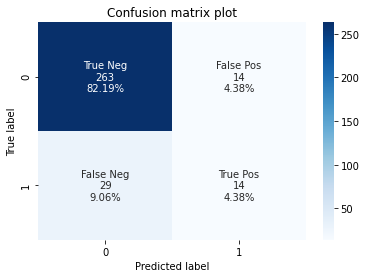

In [ ]:
generateConfusionMatrixPlot(test_y_umbral_1, y_pred)

###### Escenario 2: calidad 3-5: mala, calidad 6-8: buena.

In [ ]:
# Fit grid search
best_model = clf.fit(train_x, train_y_umbral_2)

In [ ]:
# View best hyperparameters
print('Best penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
print('Best solver:', best_model.best_estimator_.get_params()['solver'])
print('Best max_iter:', best_model.best_estimator_.get_params()['max_iter'])

Best penalty: l2
Best C: 1.0
Best solver: liblinear
Best max_iter: 200


In [ ]:
# Prediction using the best model
y_pred = best_model.predict(test_x)

printMetrics(test_y_umbral_2, y_pred)

Accuracy:  0.753125

AUC:  0.7513049962714393

Confusion matrix:
 [[108  41]
 [ 38 133]]

Classification report:
               precision    recall  f1-score   support

           0       0.74      0.72      0.73       149
           1       0.76      0.78      0.77       171

    accuracy                           0.75       320
   macro avg       0.75      0.75      0.75       320
weighted avg       0.75      0.75      0.75       320



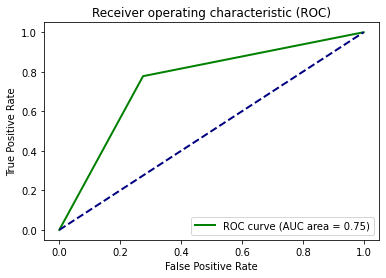

In [ ]:
generateRoc(test_y_umbral_2, y_pred)

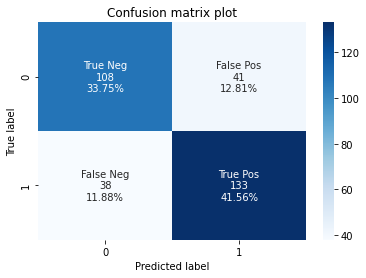

In [ ]:
generateConfusionMatrixPlot(test_y_umbral_2, y_pred)

##### Árbol de decisión

In [ ]:
# Setting hyperparameters to test
criterion = ['gini', 'entropy']
splitter = ['best', 'random']
random_state = [0]

# Create hyperparameter options
hyperparameters = dict(criterion=criterion, splitter=splitter, random_state=random_state)

# Create grid search using K-fold cross validation
clf = GridSearchCV(dt_model, hyperparameters, cv=cv, verbose=0)

###### Escenario 1: calidad 3-6: mala, calidad 7-8: buena.

In [ ]:
# Fit grid search
best_model = clf.fit(train_x, train_y_umbral_1)

In [ ]:
# View best hyperparameters
print('Best criterion:', best_model.best_estimator_.get_params()['criterion'])
print('Best splitter:', best_model.best_estimator_.get_params()['splitter'])
print('Random state:', best_model.best_estimator_.get_params()['random_state'])

Best criterion: gini
Best splitter: best
Random state: 0


In [ ]:
# Prediction using the best model
y_pred = best_model.predict(test_x)

printMetrics(test_y_umbral_1, y_pred)

Accuracy:  0.875

AUC:  0.741163630257745

Confusion matrix:
 [[256  21]
 [ 19  24]]

Classification report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93       277
           1       0.53      0.56      0.55        43

    accuracy                           0.88       320
   macro avg       0.73      0.74      0.74       320
weighted avg       0.88      0.88      0.88       320



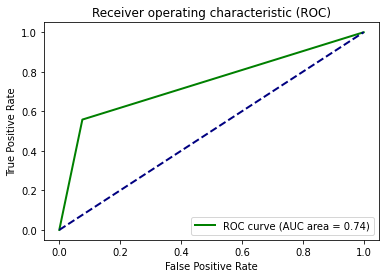

In [ ]:
generateRoc(test_y_umbral_1, y_pred)

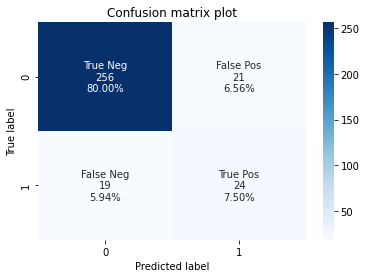

In [ ]:
generateConfusionMatrixPlot(test_y_umbral_1, y_pred)

###### Escenario 2: calidad 3-5: mala, calidad 6-8: buena.

In [ ]:
# Fit grid search
best_model = clf.fit(train_x, train_y_umbral_2)

In [ ]:
# View best hyperparameters
print('Best criterion:', best_model.best_estimator_.get_params()['criterion'])
print('Best splitter:', best_model.best_estimator_.get_params()['splitter'])
print('Random state:', best_model.best_estimator_.get_params()['random_state'])

Best criterion: gini
Best splitter: best
Random state: 0


In [ ]:
# Prediction using the best model
y_pred = best_model.predict(test_x)

printMetrics(test_y_umbral_2, y_pred)

Accuracy:  0.740625

AUC:  0.7400408179284901

Confusion matrix:
 [[109  40]
 [ 43 128]]

Classification report:
               precision    recall  f1-score   support

           0       0.72      0.73      0.72       149
           1       0.76      0.75      0.76       171

    accuracy                           0.74       320
   macro avg       0.74      0.74      0.74       320
weighted avg       0.74      0.74      0.74       320



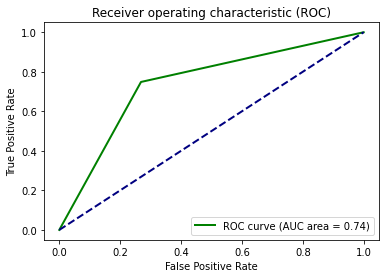

In [ ]:
generateRoc(test_y_umbral_2, y_pred)

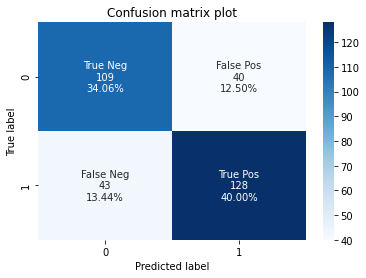

In [ ]:
generateConfusionMatrixPlot(test_y_umbral_2, y_pred)

##### KNN

In [ ]:
# Setting hyperparameters to test
weights = ['uniform', 'distance']
algorithm = ['ball_tree', 'kd_tree', 'brute', 'auto']
n_neighbors = [5, 10, 15]
p = [1, 2, 5]

# Create hyperparameter options
hyperparameters = dict(weights=weights, algorithm=algorithm, n_neighbors=n_neighbors, p=p)

# Create grid search using K-fold cross validation
clf = GridSearchCV(knn_model, hyperparameters, cv=cv, verbose=0)

###### Escenario 1: calidad 3-6: mala, calidad 7-8: buena.

In [ ]:
# Fit grid search
best_model = clf.fit(train_x, train_y_umbral_1)

In [ ]:
# View best hyperparameters
print('Best weights:', best_model.best_estimator_.get_params()['weights'])
print('Best algorithm:', best_model.best_estimator_.get_params()['algorithm'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best p:', best_model.best_estimator_.get_params()['p'])

Best weights: distance
Best algorithm: ball_tree
Best n_neighbors: 15
Best p: 1


In [ ]:
# Prediction using the best model
y_pred = best_model.predict(test_x)

printMetrics(test_y_umbral_1, y_pred)

Accuracy:  0.890625

AUC:  0.7305431953656284

Confusion matrix:
 [[263  14]
 [ 21  22]]

Classification report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       277
           1       0.61      0.51      0.56        43

    accuracy                           0.89       320
   macro avg       0.77      0.73      0.75       320
weighted avg       0.88      0.89      0.89       320



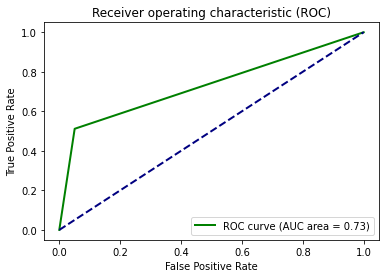

In [ ]:
generateRoc(test_y_umbral_1, y_pred)

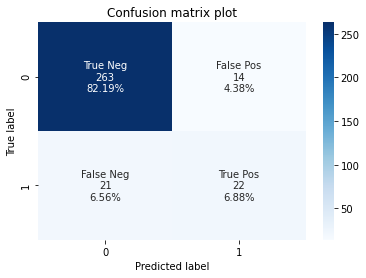

In [ ]:
generateConfusionMatrixPlot(test_y_umbral_1, y_pred)

###### Escenario 2: calidad 3-5: mala, calidad 6-8: buena.

In [ ]:
# Fit grid search
best_model = clf.fit(train_x, train_y_umbral_2)

In [ ]:
# View best hyperparameters
print('Best weights:', best_model.best_estimator_.get_params()['weights'])
print('Best algorithm:', best_model.best_estimator_.get_params()['algorithm'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best p:', best_model.best_estimator_.get_params()['p'])

Best weights: distance
Best algorithm: ball_tree
Best n_neighbors: 15
Best p: 1


In [ ]:
# Prediction using the best model
y_pred = best_model.predict(test_x)

printMetrics(test_y_umbral_2, y_pred)

Accuracy:  0.7875

AUC:  0.7826052827818988

Confusion matrix:
 [[106  43]
 [ 25 146]]

Classification report:
               precision    recall  f1-score   support

           0       0.81      0.71      0.76       149
           1       0.77      0.85      0.81       171

    accuracy                           0.79       320
   macro avg       0.79      0.78      0.78       320
weighted avg       0.79      0.79      0.79       320



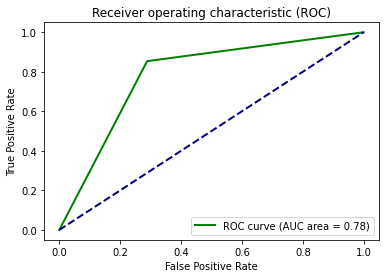

In [ ]:
generateRoc(test_y_umbral_2, y_pred)

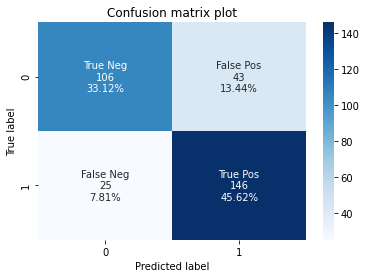

In [ ]:
generateConfusionMatrixPlot(test_y_umbral_2, y_pred)

##### Redes neuronales

In [ ]:
# Setting hyperparameters to test
hidden_layer_sizes = [(10,30,10), (20,), (3,5,)]
activation = ['tanh', 'relu']
solver = ['sgd', 'adam']
alpha = [0.0001, 0.05]
learning_rate = ['constant','adaptive']

# Create hyperparameter options
hyperparameters = dict(hidden_layer_sizes=hidden_layer_sizes, 
                       activation=activation, solver=solver, 
                       alpha=alpha, learning_rate=learning_rate)

# Create grid search using K-fold cross validation
clf = GridSearchCV(nn_model, hyperparameters, cv=cv, verbose=0)

###### Escenario 1: calidad 3-6: mala, calidad 7-8: buena.

In [ ]:
# Fit grid search
best_model = clf.fit(train_x, train_y_umbral_1)

In [ ]:
# View best hyperparameters
print('Best hidden_layer_size:', best_model.best_estimator_.get_params()['hidden_layer_sizes'])
print('Best activation:', best_model.best_estimator_.get_params()['activation'])
print('Best solver:', best_model.best_estimator_.get_params()['solver'])
print('Best alpha:', best_model.best_estimator_.get_params()['alpha'])
print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])

print('Best parameters found:\n', clf.best_params_)

Best hidden_layer_size: (20,)
Best activation: tanh
Best solver: adam
Best alpha: 0.0001
Best learning_rate: constant
Best parameters found:
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'adam'}


In [ ]:
# Prediction using the best model
y_pred = best_model.predict(test_x)

printMetrics(test_y_umbral_1, y_pred)

Accuracy:  0.8625

AUC:  0.6357148854000504

Confusion matrix:
 [[262  15]
 [ 29  14]]

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92       277
           1       0.48      0.33      0.39        43

    accuracy                           0.86       320
   macro avg       0.69      0.64      0.66       320
weighted avg       0.84      0.86      0.85       320



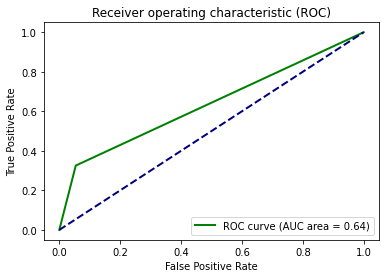

In [ ]:
generateRoc(test_y_umbral_1, y_pred)

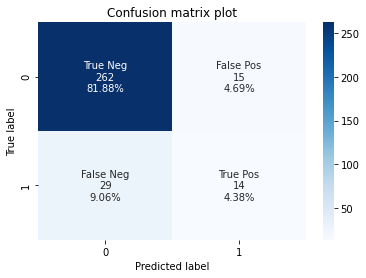

In [ ]:
generateConfusionMatrixPlot(test_y_umbral_1, y_pred)

###### Escenario 2: calidad 3-5: mala, calidad 6-8: buena.

In [ ]:
# Fit grid search
best_model = clf.fit(train_x, train_y_umbral_2)

In [ ]:
# View best hyperparameters
print('Best hidden_layer_size:', best_model.best_estimator_.get_params()['hidden_layer_sizes'])
print('Best activation:', best_model.best_estimator_.get_params()['activation'])
print('Best solver:', best_model.best_estimator_.get_params()['solver'])
print('Best alpha:', best_model.best_estimator_.get_params()['alpha'])
print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])

print('Best parameters found:\n', clf.best_params_)

Best hidden_layer_size: (10, 30, 10)
Best activation: tanh
Best solver: adam
Best alpha: 0.0001
Best learning_rate: constant
Best parameters found:
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'constant', 'solver': 'adam'}


In [ ]:
# Prediction using the best model
y_pred = best_model.predict(test_x)

printMetrics(test_y_umbral_2, y_pred)

Accuracy:  0.746875

AUC:  0.7458887711448643

Confusion matrix:
 [[109  40]
 [ 41 130]]

Classification report:
               precision    recall  f1-score   support

           0       0.73      0.73      0.73       149
           1       0.76      0.76      0.76       171

    accuracy                           0.75       320
   macro avg       0.75      0.75      0.75       320
weighted avg       0.75      0.75      0.75       320



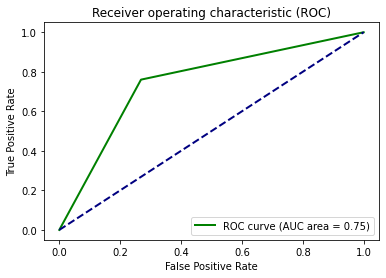

In [ ]:
generateRoc(test_y_umbral_2, y_pred)

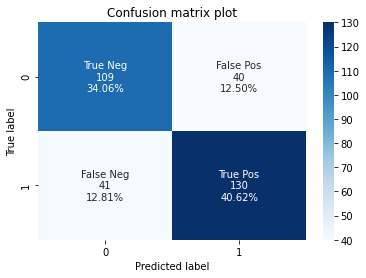

In [ ]:
generateConfusionMatrixPlot(test_y_umbral_2, y_pred)